In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


<h1 style="text-align:center; color:#5A6ACD; font-weight:bold; font-size:38px;">Image Classification With CNN</h1>


<div style="text-align: center;">
    <img src="https://www.shutterstock.com/image-photo/portrait-adorable-labrador-puppy-scottish-600nw-2379672403.jpg" alt="Centered Image">
</div>

# Dogs vs. Cats Dataset  

## Introduction  
The **Dogs vs. Cats** dataset is a widely used dataset for binary image classification tasks. It contains images of**dogs** and **cats**, making it an excellent choice for training deep learning models, particularly **Convolutional Neural Networks (CNNs)**.  

---

## Dataset Details  
- **Total Number of Images**: 25,000  
- **Categories**:  
  - `dog`  
  - `cat`  
- **Image Format**: `.jpg`  
- **Image Size**: Varying (non-uniform)  
- **Labelsing**:  
  - The class labels are embedded in the filenames (e.g., dog.1.jpg, cat.2.jpg). 
  - There is no separate label file; labels are derived from the filenames.  

---

## Data Organization  
The dataset is typically divided into:  
- **Training Set**: Used for model training.
- **Validation/Test Set**: Used to evaluate model performance.  

---


<h1 style="text-align:left; color:#6A5ACD; font-weight:bold; font-size:28px; font-family:Arial, sans-serif;">1. Import Libraries</h1>

In [2]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os, shutil
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, img_to_array


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)


#Remove Warnings
import warnings
warnings.filterwarnings('ignore')

<a id="1"></a>
# <div style="text-align:center; border-radius:25px 70px; padding:9px; color:white; margin:0; font-size:150%; font-family:Pacifico; background-color:#6A5ACD; overflow:hidden"><b>Data Loading and Initial Exploration</b></div>

## Unzipping the Dogs vs. Cats Dataset

In [3]:
!unzip -q "/kaggle/input/dogs-vs-cats/train.zip"

In [4]:
!unzip -q "/kaggle/input/dogs-vs-cats/test1.zip"

<h1 style="text-align:left; color:#6A5ACD; font-weight:bold; font-size:28px; font-family:Arial, sans-serif;">2. Prepare Data</h1>

In [5]:
def prepare_data(train_path, val_size=0.15, test_size=0.15, random_state=42):

    train_filenames = os.listdir(train_path)
    train_categories = [1 if filename.split(".")[0] == 'dog' else 0 for filename in train_filenames]

    df = pd.DataFrame({
        'filename': train_filenames,
        'category': train_categories
    })

    
    train_df, temp_df = train_test_split(df, test_size=(val_size + test_size), stratify=df["category"], random_state=random_state)

    val_ratio = val_size / (val_size + test_size)  
    val_df, test_df = train_test_split(temp_df, test_size=(1 - val_ratio), stratify=temp_df["category"], random_state=random_state)

    return train_df, val_df, test_df

In [6]:
train_path = "/kaggle/working/train"
train_df, val_df, test_df = prepare_data(train_path)
print(f"Total Training Images: {len(train_df)}")
print(f"Total Validation Images: {len(val_df)}")
print(f"Total Test Images: {len(test_df)}")

Total Training Images: 17500
Total Validation Images: 3750
Total Test Images: 3750


In [7]:
train_df.head()


,filename,category
23804,dog.7677.jpg,1
21687,cat.2744.jpg,0
7756,dog.12003.jpg,1
13264,cat.1596.jpg,0
448,dog.3125.jpg,1


In [8]:
val_df.head()


,filename,category
1206,dog.3142.jpg,1
19776,cat.4277.jpg,0
20574,cat.10821.jpg,0
6679,cat.11481.jpg,0
12893,dog.52.jpg,1


In [9]:
test_df.head()

,filename,category
22026,dog.7266.jpg,1
19806,cat.4040.jpg,0
24558,dog.5860.jpg,1
4542,cat.3044.jpg,0
13443,dog.889.jpg,1


<h1 style="text-align:left; color:#6A5ACD; font-weight:bold; font-size:28px; font-family:Arial, sans-serif;">3. Inspecting Directory Structure

The dataset is organized into **three main directories**: `train`, `validation`, and `test`, each containing images of cats and dogs.

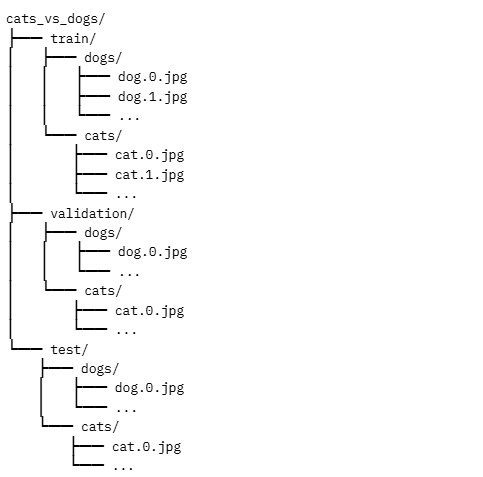

In [10]:
def subsampled_dataset(df, source_path, base_dir, dataset_type):
    dogs_dir = os.path.join(base_dir, dataset_type, "dogs")
    cats_dir = os.path.join(base_dir, dataset_type, "cats")
    os.makedirs(dogs_dir, exist_ok=True)
    os.makedirs(cats_dir, exist_ok=True)
    source_path = Path(source_path)

    for category, num, folder in [("cat", 0, cats_dir), ("dog", 1, dogs_dir)]:
        for i, filename in enumerate(df[df["category"] == num]["filename"]):
            src = source_path / filename
            dst = os.path.join(folder, f"{category}{i}.jpg") 
            shutil.copyfile(src, dst)



In [11]:
base_dir = "cats_vs_dogs"
subsampled_dataset(train_df, train_path, base_dir, "train")

In [12]:
subsampled_dataset(val_df, train_path, base_dir, "validation")

In [13]:
subsampled_dataset(test_df, train_path, base_dir, "test")

In [14]:
cats = len(os.listdir("/kaggle/working/cats_vs_dogs/train/cats"))
dogs = len(os.listdir("/kaggle/working/cats_vs_dogs/train/dogs"))
cats+dogs

17500

The number of training samples is **17,500**, so the total count of dogs and cats after subsampling is **17,500**.

<h1 style="text-align:left; color:#6A5ACD; font-weight:bold; font-size:28px; font-family:Arial, sans-serif;">4. Display sample images</h1>

In [15]:
def display_images(df, image_path, num_images=6):

    sample_data = df.sample(n=num_images).reset_index(drop=True)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    
    for i, ax in enumerate(axes):
        filename = sample_data.loc[i, "filename"]
        img = Image.open(os.path.join(image_path, filename))

        img = img.resize((128, 128))
        
        label = "Dog" if sample_data.loc[i, "category"] == 1 else "Cat"

        ax.imshow(img)
        ax.set_title(label, fontsize=20)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

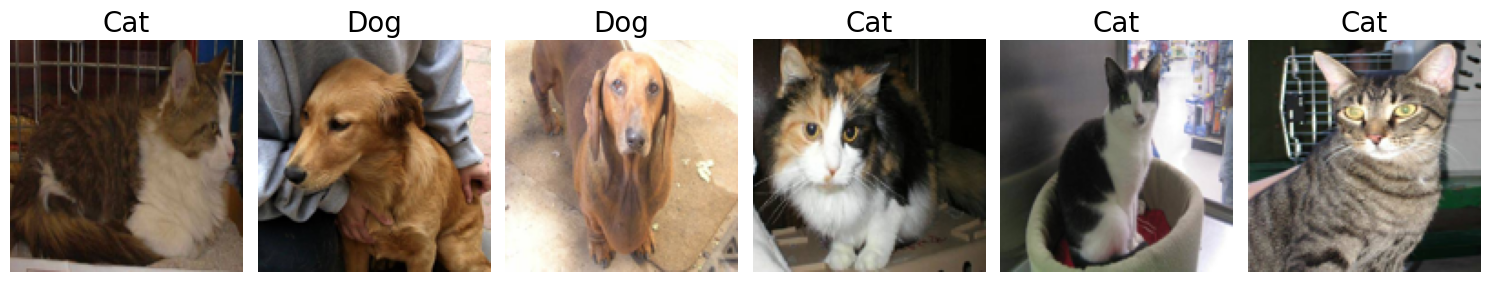

In [16]:
display_images(train_df, train_path)

<a id="1"></a>
# <div style="text-align:center; border-radius:25px 70px; padding:9px; color:white; margin:0; font-size:150%; font-family:Pacifico; background-color:#6A5ACD; overflow:hidden"><b>Data Preprocessing and Model Building</b></div>

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation data should not be augmented, only rescaled
val_datagen = ImageDataGenerator(rescale=1./255)

# Create training and validation generators
train_generator = train_datagen.flow_from_directory(
    '/kaggle/working/cats_vs_dogs/train',  # Use the appropriate path
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    '/kaggle/working/cats_vs_dogs/validation',  # Use the appropriate path
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)


Found 17500 images belonging to 2 classes.
Found 3750 images belonging to 2 classes.


In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  # 1 unit because it's a binary classification (cat vs dog)
])

# Summary of the model
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [20]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping]
)


Epoch 1/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 100s 170ms/step - accuracy: 0.5361 - loss: 0.6874 - val_accuracy: 0.6187 - val_loss: 0.6426
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 86s 155ms/step - accuracy: 0.6114 - loss: 0.6527 - val_accuracy: 0.6941 - val_loss: 0.5839
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 84s 151ms/step - accuracy: 0.6817 - loss: 0.5942 - val_accuracy: 0.7507 - val_loss: 0.5195
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 82s 149ms/step - accuracy: 0.7162 - loss: 0.5562 - val_accuracy: 0.7520 - val_loss: 0.5034
Epoch 5/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 83s 150ms/step - accuracy: 0.7327 - loss: 0.5317 - val_accuracy: 0.7907 - val_loss: 0.4546
Epoch 6/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 83s 150ms/step - accuracy: 0.7447 - loss: 0.5176 - val_accuracy: 0.8075 - val_loss: 0.4614
Epoch 7/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 84s 152ms/step - accuracy: 0.7506 - loss: 0.5063 - val_accuracy: 0.8021 - val_loss: 0.4371
Epoch 8/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 83s 150ms/step - accuracy: 0.7695 - loss: 

In [23]:
# Define the test data generator (no augmentation, only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create the test data generator
test_generator = test_datagen.flow_from_directory(
    '/kaggle/working/cats_vs_dogs/test',  # Use the appropriate path for the test data
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)


Found 3750 images belonging to 2 classes.


In [24]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)

# Print the test accuracy and loss
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.8182 - loss: 0.3996
Test Accuracy: 82.85%
Test Loss: 0.3847


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


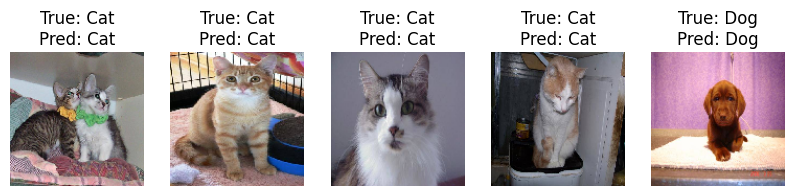

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot images with true and predicted labels
def plot_predictions(generator, model, num_samples=5):
    # Get a batch of images and labels from the test set
    images, labels = next(generator)

    # Get model predictions for the batch
    predictions = model.predict(images)

    # Convert predictions from probabilities to labels
    predicted_labels = (predictions > 0.5).astype("int32")  # 0 if Cat, 1 if Dog

    # Plot images along with their true and predicted labels
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        img = images[i]
        true_label = 'Dog' if labels[i] == 1 else 'Cat'
        predicted_label = 'Dog' if predicted_labels[i] == 1 else 'Cat'
        
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis('off')
    plt.show()

# Use the val_generator to predict on a batch of images from the validation set
plot_predictions(val_generator, model, num_samples=5)


<a id="1"></a>
# <div style="text-align:center; border-radius:25px 70px; padding:9px; color:white; margin:0; font-size:150%; font-family:Pacifico; background-color:#6A5ACD; overflow:hidden"><b>Conclusion</b></div>


In this project, we successfully built and trained a **Convolutional Neural Network (CNN)** to classify images of **cats** and **dogs** using the well-known **Dogs vs Cats** dataset. This task is a great example of how CNNs excel in image classification problems by leveraging their ability to capture spatial hierarchies and learn complex visual patterns.

Throughout the project, we:

- **Preprocessed the data** by resizing images and applying normalization and data augmentation techniques.
- Built a **simple CNN architecture** with three convolutional layers, pooling layers, and dense layers to handle the image classification task.
- Used techniques like **early stopping** to avoid overfitting and **evaluated the model** on the test dataset to assess its performance.
- Implemented **data augmentation** to improve the model's ability to generalize to new, unseen images.
  
The model demonstrated good performance on the validation data, with an **accuracy of 79%** after 10 epochs. We also showed how the model can make predictions on new test images, comparing the true and predicted labels to validate the model’s predictions visually.

### Key Takeaways:
- **Convolutional layers** are the backbone of CNNs, enabling the network to automatically learn important features like edges and textures, progressively building up to more complex shapes.
- **Data augmentation** plays a crucial role in improving the model’s robustness and generalization by introducing random transformations.
- **Early stopping** is an effective way to prevent overfitting and ensure the model doesn't learn unnecessary patterns from the training data.
  
### Future Directions:
- **Improvement in accuracy**: Further improvements can be achieved by experimenting with deeper architectures, **transfer learning**, or additional hyperparameter tuning.
- **Real-World Applications**: The techniques learned here can be applied to other real-world image classification tasks like facial recognition, medical imaging, and object detection.

By understanding and implementing these concepts, we can create more sophisticated and robust models for a variety of image classification problems.
